In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import socketio
import eventlet
from flask import Flask
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv2D, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from imgaug import augmenters as iaa
from io import BytesIO
from PIL import Image
import base64
from sklearn.utils import shuffle
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

def getName(filePath):
    return filePath.split('\\')[-1]

def importDataInfo(path):
    columns = ['Center', 'Left', 'Right', 'Steering', 'Throttle', 'Brake', 'Speed']
    data = pd.read_csv(os.path.join(r"C:\Users\Administrator\source\repos\self-driving-car-sim\data", 'driving_log.csv'), names=columns)
    data['Center'] = data['Center'].apply(getName)
    print('Total Images Imported:', data.shape[0])
    return data

path = r"myData"
data = importDataInfo(path)
from tensorflow.keras.preprocessing import image
import numpy as np

def preprocess_image(img_path):
    img = image.load_img(img_path, target_size=(66, 200))  # Resize to the expected input size
    img_array = image.img_to_array(img)  # Convert to numpy array
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = img_array / 255.0  # Normalize the image
    return img_array


Total Images Imported: 11603


In [2]:
def balanceData(data, display=True):
    nBin = 31
    samplesPerBin = 500
    hist, bins = np.histogram(data['Steering'], nBin)

    if display:
        center = (bins[:-1] + bins[1:]) * 0.5
        plt.bar(center, hist, width=0.06)
        plt.plot((np.min(data['Steering']), np.max(data['Steering'])), (samplesPerBin, samplesPerBin))
        plt.show()

    removeindexList = []
    for j in range(nBin):
        binDataList = []
        for i in range(len(data['Steering'])):
            if data['Steering'][i] >= bins[j] and data['Steering'][i] <= bins[j + 1]:
                binDataList.append(i)
        
        binDataList = shuffle(binDataList)
        binDataList = binDataList[samplesPerBin:]
        removeindexList.extend(binDataList)

    print('Removed Images:', len(removeindexList))
    data.drop(data.index[removeindexList], inplace=True)
    print('Remaining Images:', len(data))

    if display:
        hist, _ = np.histogram(data['Steering'], nBin)
        plt.bar(center, hist, width=0.06)
        plt.plot((np.min(data['Steering']), np.max(data['Steering'])), (samplesPerBin, samplesPerBin))
        plt.show()

    return data

In [3]:
nBin = 31
samplesPerBin = 500

hist, bins = np.histogram(data['Steering'], nBin)

removeindexList = []
for j in range(nBin):
    binDataList = []
    for i in range(len(data['Steering'])):
        if data['Steering'][i] >= bins[j] and data['Steering'][i] <= bins[j + 1]:
            binDataList.append(i)
    binDataList = shuffle(binDataList)
    binDataList = binDataList[samplesPerBin:]
    removeindexList.extend(binDataList)

print('Removed Images:', len(removeindexList))
data.drop(data.index[removeindexList], inplace=True)  # Drop rows from the data
print('Remaining Images:', len(data))

Removed Images: 6904
Remaining Images: 4699


In [4]:
def loadData(path, data):
  imagesPath = []
  steering = []
  for i in range(len(data)):
    indexed_data = data.iloc[i]
    imagesPath.append(f'{path}/IMG/{indexed_data[0]}')
    steering.append(float(indexed_data[3]))
  imagesPath = np.asarray(imagesPath)
  steering = np.asarray(steering)
  return imagesPath, steering
imagesPath, steerings = loadData(path,data)

In [5]:
from sklearn.model_selection import train_test_split
xTrain, xVal, yTrain, yVal = train_test_split(imagesPath, steerings, test_size=0.2,random_state=10)
print('Total Training Images: ',len(xTrain))
print('Total Validation Images: ',len(xVal))

Total Training Images:  3759
Total Validation Images:  940


In [6]:
def augmentImage(imgPath, steering):
    """Augment an image and its corresponding steering angle."""
    img = mpimg.imread(imgPath)

    if np.random.rand() < 0.5:
        pan = iaa.Affine(translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)})
        img = pan.augment_image(img)
    
    if np.random.rand() < 0.5:
        zoom = iaa.Affine(scale=(1, 1.2))
        img = zoom.augment_image(img)
    
    if np.random.rand() < 0.5:
        brightness = iaa.Multiply((0.2, 1.2))
        img = brightness.augment_image(img)
    
    if np.random.rand() < 0.5:
        img = cv2.flip(img, 1)
        steering = -steering  # Flip the steering angle

    return img, steering

In [7]:
def preProcess(img):
    img = img[60:135,:,:]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img,  (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img/255
    return img

In [8]:
def batchGen(imagesPath, steeringList, batchSize, trainFlag):
    """Generate batches of images and steering angles."""
    while True:
        imgBatch = []
        steeringBatch = []
        
        for i in range(batchSize):
            index = random.randint(0, len(imagesPath) - 1)
            if trainFlag:
                img, steering = augmentImage(imagesPath[index], steeringList[index])
            else:
                img = mpimg.imread(imagesPath[index])
                steering = steeringList[index]
            
            img = preProcess(img)
            imgBatch.append(img)
            steeringBatch.append(steering)
        
        yield (np.asarray(imgBatch), np.asarray(steeringBatch))

In [9]:
print('Setting UP')
def createModel():
  model = Sequential()
 
  model.add(Conv2D(24, (5, 5), (2, 2), input_shape=(66, 200, 3), activation='elu'))
  model.add(Conv2D(36, (5, 5), (2, 2), activation='elu'))
  model.add(Conv2D(48, (5, 5), (2, 2), activation='elu'))
  model.add(Conv2D(64, (3, 3), activation='elu'))
  model.add(Conv2D(64, (3, 3), activation='elu'))
 
  model.add(Flatten())
  model.add(Dense(100, activation = 'elu'))
  model.add(Dense(50, activation = 'elu'))
  model.add(Dense(10, activation = 'elu'))
  model.add(Dense(1))
 
  model.compile(Adam(lr=0.0001),loss='mse')
  return model
model = createModel()
model.summary()

Setting UP
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 31, 98, 24)        1824      
                                                                 
 conv2d_1 (Conv2D)           (None, 14, 47, 36)        21636     
                                                                 
 conv2d_2 (Conv2D)           (None, 5, 22, 48)         43248     
                                                                 
 conv2d_3 (Conv2D)           (None, 3, 20, 64)         27712     
                                                                 
 conv2d_4 (Conv2D)           (None, 1, 18, 64)         36928     
                                                                 
 flatten (Flatten)           (None, 1152)              0         
                                                                 
 dense (Dense)               (None, 100)     

In [10]:
# Parameters
dim = (64, 64)  # Resize images to 64x64 pixels
channels = 3     # RGB images
batch_size = 32  # Batch size

image_dir = 'data/IMG/'
image_paths = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir) if fname.startswith('center') and fname.endswith('.jpg')]

split_index = int(0.8 * len(image_paths))  # 80% for training
xTrain = image_paths[:split_index]
xVal = image_paths[split_index:]

yTrain = [0.0] * len(xTrain)
yVal = [0.0] * len(xVal)

def dataGen(image_paths, steering_angles, batch_size, dim, channels):
    while True:
        batch_images = []
        batch_steerings = []
        for i in range(batch_size):
            # Randomly select an image and corresponding steering angle
            index = random.randint(0, len(image_paths) - 1)
            imgPath = image_paths[index]
            steering = steering_angles[index]

            # Ensure the image exists
            if not os.path.exists(imgPath):
                print(f"Warning: Image not found at {imgPath}")
                continue

            # Load and preprocess the image
            img = image.load_img(imgPath, target_size=dim)  # Resize image
            img = image.img_to_array(img)  # Convert image to array
            batch_images.append(img)
            batch_steerings.append(steering)

        # Convert lists to arrays
        batch_images = np.array(batch_images)
        batch_steerings = np.array(batch_steerings)

        yield batch_images, batch_steerings  # Yield images and their corresponding steering angles

model = Sequential([
    Conv2D(24, (5, 5), strides=(2, 2), activation='relu', input_shape=(64, 64, 3)),
    Conv2D(36, (5, 5), strides=(2, 2), activation='relu'),
    Conv2D(48, (5, 5), strides=(2, 2), activation='relu'),
    Flatten(),
    Dense(100, activation='relu'),
    Dense(50, activation='relu'),
    Dense(10, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

print(f"xTrain paths: {xTrain[:5]}")

history = model.fit(dataGen(xTrain, yTrain, batch_size, dim, channels),
                    steps_per_epoch=300,  # Adjust according to your data
                    epochs=10,
                    validation_data=dataGen(xVal, yVal, batch_size, dim, channels),
                    validation_steps=200)  # Adjust based on validation data

xTrain paths: ['data/IMG/center_2024_12_07_19_11_01_932.jpg', 'data/IMG/center_2024_12_07_19_11_02_000.jpg', 'data/IMG/center_2024_12_07_19_11_02_072.jpg', 'data/IMG/center_2024_12_07_19_11_02_145.jpg', 'data/IMG/center_2024_12_07_19_11_02_215.jpg']
Epoch 1/10
300/300 [==============================] - 14s 44ms/step - loss: 0.9240 - val_loss: 0.0053
Epoch 2/10
300/300 [==============================] - 14s 47ms/step - loss: 0.0034 - val_loss: 0.0021
Epoch 3/10
300/300 [==============================] - 14s 47ms/step - loss: 0.0020 - val_loss: 0.0013
Epoch 4/10
300/300 [==============================] - 14s 47ms/step - loss: 0.0012 - val_loss: 9.9212e-04
Epoch 5/10
300/300 [==============================] - 14s 47ms/step - loss: 8.4948e-04 - val_loss: 7.3811e-04
Epoch 6/10
300/300 [==============================] - 14s 47ms/step - loss: 5.9774e-04 - val_loss: 6.6166e-04
Epoch 7/10
300/300 [==============================] - 14s 48ms/step - loss: 4.6174e-04 - val_loss: 5.1459e-04
Epoch 8/

Model Saved


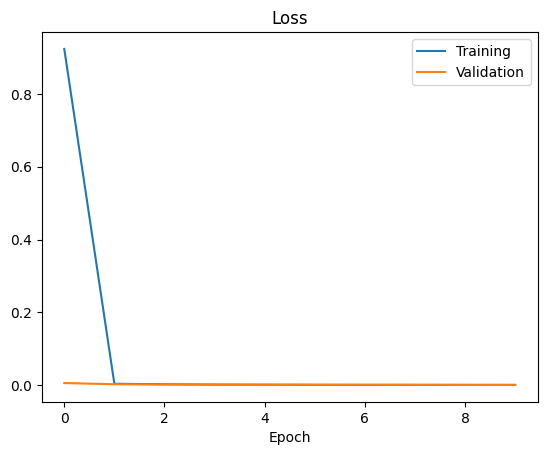

In [11]:
model.save('model.h5')
print('Model Saved')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['Training', 'Validation'])
plt.title('Loss')
plt.xlabel('Epoch')
plt.show()

In [ ]:
print('Setting UP')
#### FOR REAL TIME COMMUNICATION BETWEEN CLIENT AND SERVER
sio = socketio.Server()
#### FLASK IS A MICRO WEB FRAMEWORK WRITTEN IN PYTHON
app = Flask(__name__)  # '__main__'
 
maxSpeed = 10
 
 
def preProcess(img):
    img = img[60:135,:,:]
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img,  (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img/255
    return img
 
 
@sio.on('telemetry')
def telemetry(sid, data):
    speed = float(data['speed'])
    image = Image.open(BytesIO(base64.b64decode(data['image'])))
    image = np.asarray(image)
    image = preProcess(image)
    image = np.array([image])
    steering = float(model.predict(image))
    throttle = 1.0 - speed / maxSpeed
    print(f'{steering}, {throttle}, {speed}')
    sendControl(steering, throttle)
 
 
@sio.on('connect')
def connect(sid, environ):
    print('Connected')
    sendControl(0, 0)
 
 
def sendControl(steering, throttle):
    sio.emit('steer', data={
        'steering_angle': steering.__str__(),
        'throttle': throttle.__str__()
    })
 
 
if __name__ == '__main__':
    model = load_model('model.h5')
    app = socketio.Middleware(sio, app)
    ### LISTEN TO PORT 4567
    eventlet.wsgi.server(eventlet.listen(('', 4567)), app)

Setting UP


(4592) wsgi starting up on http://0.0.0.0:4567
